# Error metrics for the Oscillatory model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)
      
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21

def batch_simulator_augment01(prior_samples, n_obs):   
    """
    Simulate multiple oscillatory model data sets with missing values and binary augmentation
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data 

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [4]:
n_params = 500
true_params = prior(n_params) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

## Sample from BayesFlow using the different encodings

In [5]:
%%time

# Augment by 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=10000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), true_params)
metrics_augment01 = display_metrics(v_augment01)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
NRMSE(k_1): 0.001 ± 0.000
NRMSE(k_2): 0.008 ± 0.001
R²(k_1): 1.000 ± 0.000
R²(k_2): 0.998 ± 0.000
Wall time: 7min 59s


In [7]:
%%time

# Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_time = np.empty((n_params, 10000, 2), dtype=np.float32)
for m in range(n_params):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_time = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_time[0, :, 0] = x_augment01[m, present_indices, 0]
    x_time[0, :, 1] = time_points[present_indices]
    param_samples_time[m] = amortizer.sample(x_time, n_samples=10000)
v_time = bootstrap_metrics(np.swapaxes(param_samples_time, 0, 1), true_params)
metrics_time = display_metrics(v_time)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
NRMSE(k_1): 0.019 ± 0.007
NRMSE(k_2): 0.013 ± 0.001
R²(k_1): 0.995 ± 0.004
R²(k_2): 0.995 ± 0.001
Wall time: 4min 55s


## Plotting methods

In [8]:
def true_vs_estimated(axarr, theta_true, theta_est, param_names):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values. """
        
    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(param_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_est[:, j], theta_true[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSE
        rmse = np.sqrt(np.mean( (theta_est[:, j] - theta_true[:, j])**2 ))
        nrmse = rmse / (theta_true[:, j].max() - theta_true[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=11)
        
        # Compute R2
        r2 = r2_score(theta_true[:, j], theta_est[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=11)
        
        axarr[j].set_ylabel('True')
        if j == len(param_names) - 1:
            # Label plot
            axarr[j].set_xlabel('Estimated')
        axarr[j].set_title(param_names[j], fontsize=11.5)
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)

In [9]:
def bar_chart(ax, values, column, category, se=None, y_lim=None):
    ax[column].set_title(category, pad=5)
    if se is not None:
        ax[column].bar(x=[1,2], height=values, yerr=se, capsize=10, width=1.0, color=[(0.91, 0.44, 0.32), (0.16, 0.62, 0.56)])
    else: 
        ax[column].bar(x=[1], height=values[0], width=1.0, color=[(0.91, 0.44, 0.32)], label='Augment by $0/1$')        
        ax[column].bar(x=[2], height=values[1], width=1.0, color=[(0.16, 0.62, 0.56)], label='Time labels')
    ax[column].set_xticks([1,2])
    ax[column].set_xticklabels(['',''])
    ax[column].tick_params(bottom=False)
    if y_lim is not None:
        ax[column].set_ylim(y_lim)

## Compare means 

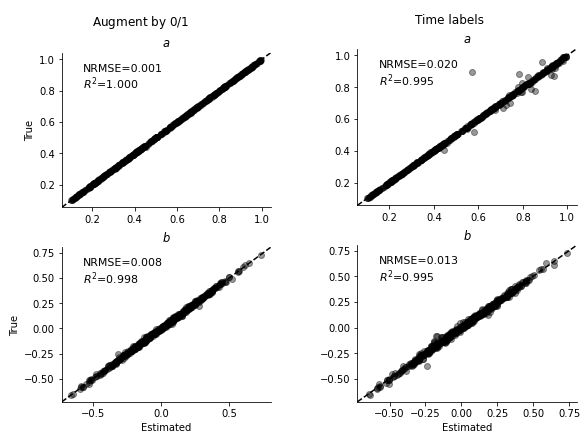

In [10]:
# Compare means of MCMC and BayesFlow samples

fig = plt.figure(figsize=(8, 6), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.15)
all_axes = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

for ix, (samples, label) in enumerate([
    (param_samples_augment01, "Augment by $0/1$"),
    (param_samples_time, "Time labels")
]):
    bayesflow_means = np.mean(samples, axis=1)
    axes = all_axes[ix].flat
    true_vs_estimated(axes, true_params, bayesflow_means, ["$a$", "$b$"])
    subfigs[ix].suptitle(label)
    if ix > 0:
        for ax in axes:
            ax.set_ylabel(None)
plt.suptitle(" ", fontsize=0.1)

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Osc_true_vs_estimated_mean.{fmt}", dpi=300, bbox_inches='tight')

## Bar chart for error metrics

In [14]:
loss_augment01 = np.mean(np.array([-11.312827, -11.174583, -11.491144, -11.34953, -11.350343, -11.1767025, -11.520441, -11.21283, -11.335095, -11.352485, -11.373265, -11.436376, -11.445673, -11.336836, -11.452516, -11.292303, -11.420124, -11.283829, -11.299255, -11.508749, -11.246281, -11.438396, -11.259842, -11.274952, -11.4855995, -11.598723, -11.416227, -11.453756, -11.343292, -11.30416, -11.34696, -11.344499, -11.244532, -11.217777, -11.274616, -11.544768, -11.231199, -11.201099, -11.367277, -11.3769, -11.324678, -11.534828, -11.50357, -11.322519, -11.120439, -11.328339, -11.374999, -11.415031, -11.385593, -11.280419, -11.274411, -11.429356, -11.2284155, -11.315071, -11.2983, -11.277407, -11.407372, -11.131746, -11.105797, -11.547459, -11.439615, -11.408998, -11.414858, -11.297711, -11.33034, -11.23915, -11.504116, -11.305727, -11.10324, -11.439291, -11.385651, -11.453447, -11.270701, -11.100763, -11.354677, -11.470198, -11.336021, -11.263182, -11.286778, -11.295979, -11.216522, -11.3121, -11.549753, -11.513554, -11.307205, -11.245073, -11.390588, -11.230137, -11.549482, -11.411162, -11.514138, -11.279615, -11.464417, -11.386593, -11.418659, -11.170611, -11.539554, -11.416174, -11.306889, -11.315138, -11.4506035, -11.37735, -11.465313, -11.38415, -11.231388, -11.191742, -11.360739, -11.297031, -11.440768, -11.172872, -11.368948, -11.335129, -11.297438, -11.347108, -11.340324, -11.216764, -11.298919, -11.358666, -11.297394, -11.433748, -11.411287, -11.464376, -11.39901, -11.31809, -11.401033, -11.470043, -11.373344, -11.31814, -11.194681, -11.277825, -11.368221, -11.348021, -11.386158, -11.386169, -11.517862, -11.273134, -11.352417, -11.362048, -11.247778, -11.427988, -11.3673115, -11.30695, -11.481028, -11.457045, -11.313972, -11.304134, -11.169075, -11.413168, -11.343816, -11.395181, -11.36023, -11.393622, -11.310399, -11.34226, -11.196285, -11.4231415, -11.262364, -11.231655, -11.346523, -11.319214, -11.021559, -11.362833, -11.312733, -11.451799, -11.230116, -11.269184, -11.412487, -11.259496, -11.224335, -11.369343, -11.254908, -11.236086, -11.484886, -11.256083, -11.3324795, -11.43103, -11.5765705, -11.445688, -11.413246, -11.182905, -11.429469, -11.374935, -11.446835, -11.390484, -11.353888, -11.506386, -11.470686, -11.360651, -11.26198, -11.353759, -11.151575, -11.422995, -11.16588, -11.333593, -11.388078, -11.574321, -11.172756, -11.294996, -11.3635435, -11.364593, -11.320897, -11.470074, -11.382883, -11.3446865, -11.398876, -11.392433, -11.188978, -11.376637, -11.043821, -11.432099, -11.253274, -11.423178, -11.423221, -11.401787, -11.339691, -11.254498, -11.386529, -11.352721, -11.45655, -11.403008, -11.284454, -11.340748, -11.216794, -11.361982, -11.44681, -11.184351, -11.4850445, -11.5033865, -11.32525, -11.180592, -11.377445, -11.332632, -11.369236, -11.458436, -11.2137165, -11.386133, -11.460324, -11.4397545, -11.109142, -11.081461, -11.452188, -11.287369, -11.3275795, -11.437707, -11.214397, -11.287601, -11.545792, -11.208458, -11.442523, -11.353772, -11.304196, -11.464584, -11.146414, -11.38166, -11.340172, -11.503758, -11.270136, -11.145861, -11.3558445, -11.473922, -11.291861, -11.360006, -11.510453, -11.475445, -11.245505, -11.1312685, -11.315609, -11.514875, -11.185341, -11.335798, -11.320751, -11.274134, -11.386893, -11.495647, -11.257208, -11.424928, -11.384481, -11.714711, -11.436271, -11.5040455, -11.333371, -11.408474, -11.401088, -11.426068, -11.407517, -11.310266, -11.419941, -11.261434, -11.344081, -11.326039, -11.175428, -11.298983, -11.315315, -11.565071, -11.149275, -11.337305, -11.335945, -11.456263, -11.333146, -11.260868, -11.305961, -11.483194, -11.3631735, -11.2752285, -11.293722, -11.412569, -11.374313, -11.464493, -11.542662, -11.277338, -11.364401, -11.439419, -11.269112, -11.180802, -11.522101, -11.180454, -11.341984, -11.402245, -11.551733, -11.404772, -11.400234, -11.329182, -11.340136, -11.234293, -11.362833, -11.337024, -11.33011, -11.569216, -11.3029175, -11.264623, -11.299837, -11.380904, -11.484749, -11.34893, -11.424982, -11.488331, -11.412821, -11.426656, -11.396587, -11.390936, -11.376776, -11.530234, -11.363839, -11.214468, -11.38965, -11.322752, -11.216276, -11.270953, -11.280171, -11.37245, -11.335272, -11.2790165, -11.62438, -11.302601, -11.434746, -11.424668, -11.374245, -11.215779, -11.200866, -11.416391, -11.201435, -11.362857, -11.520446, -11.367598, -11.300839, -11.413307, -11.361955, -11.43073, -11.31543, -11.27227, -11.286851, -11.23157, -11.37681, -11.290005, -11.433572, -11.19304, -11.334925, -11.473173, -11.254469, -11.212296, -11.195299, -11.331917, -11.173122, -11.3886, -11.259054, -11.468435, -11.377784, -11.416018, -11.487949, -11.329145, -11.406764, -11.351076, -11.393177, -11.422779, -11.499172, -11.289316, -11.107824, -11.285099, -11.283012, -11.448017, -11.364161, -11.405796, -11.360675, -11.261029, -11.359018, -11.338825, -11.360548, -11.255852, -11.5389385, -11.388319, -11.329632, -11.367027, -11.389645, -11.360139, -11.337093, -11.297023, -11.270615, -11.467862, -11.263513, -11.372263, -11.406689, -11.214963, -11.228869, -11.477475, -11.421343, -11.179537, -11.30806, -11.19905, -11.3630295, -11.2442875, -11.341852, -11.453087, -11.373041, -11.356049, -11.210854, -11.514437, -11.422377, -11.468382, -11.41662, -11.257486, -11.665153, -11.356576, -11.416355, -11.281116, -11.21645, -11.439146, -11.3438835, -3.195878, -11.371874, -11.178524, -11.300493, -11.278366, -11.295987, -11.470969, -11.424295, -11.46891, -11.4106655, -11.429693, -11.271695, -11.444584, -11.42244, -11.2680025, -11.325708, -11.320042, -11.342579, -11.371444, -11.191099, -11.206766, -11.492064, -11.385462, -11.319805, -11.440731, -11.260797, -11.262718, -11.372693, -11.376067, -11.331659, -11.418947, -11.33827, -11.520264, -11.368529, -11.191342, -11.116044, -11.377705, -11.4104805, -11.269964, -11.492606, -11.389082, -11.381653, -11.336368, -11.571978, -11.35133, -11.336763, -11.40127, -11.285142, -11.355997, -11.27283, -11.449295, -11.243948, -11.292927, -11.545476, -11.213177, -11.394804, -11.182644, -11.46851, -11.303932, -11.450861, -11.404432, -11.338303, -11.411713, -11.517141, -11.310735, -11.345728, -11.434853, -11.290829, -11.3492155, -11.381801, -11.243696, -11.319355, -11.463936, -11.206835, -11.260571, -11.347321, -11.375863, -11.433069, -11.401207, -11.261237, -11.393834, -11.337832, -11.503036, -11.396126, -11.373581, -11.387507, -11.288585, -11.172438, -11.602282, -11.460853, -11.080372, -11.248776, -11.372078, -11.404896, -11.451135, -11.442495, -11.288187, -11.44408, -11.159327, -10.990011, -11.2488365, -11.397772, -11.362063, -11.3838005, -11.323946, -11.441763, -11.235678, -11.421584, -11.473424, -11.289373, -11.392588, -11.238741, -11.120453, -11.468743, -11.418219, -11.354956, -11.410639, -11.265908, -11.297354, -11.428841, -11.424044, -11.411037, -11.258163, -11.260523, -11.446352, -11.400316, -11.383987, -11.402367, -11.273447, -11.482141, -11.201771, -11.343438, -11.48984, -11.479645, -11.254754, -11.433102, -11.374642, -11.213385, -11.392593, -11.226967, -11.4235325, -11.460888, -11.435729, -11.466715, -11.427572, -11.333019, -11.378357, -11.183845, -11.322759, -11.389606, -11.332468, -11.360011, -11.259859, -11.345174, -11.175943, -11.244886, -11.423917, -11.170374, -11.296561, -11.524785, -11.456334, -11.10087, -11.407841, -11.187657, -11.412976, -11.427242, -11.340984, -11.358219, -11.411294, -11.263051, -11.5887985, -11.391022, -11.284192, -11.284132, -11.224595, -11.121582, -11.4005165, -11.248186, -11.360951, -11.225159, -11.474405, -11.450335, -11.449589, -11.250776, -11.14823, -11.311788, -11.287942, -11.248231, -11.2573395, -11.583723, -11.229525, -11.414209, -11.504581, -11.320653, -11.333056, -11.323481, -11.431416, -11.478998, -11.402904, -11.084797, -11.338783, -11.334242, -11.143263, -11.371405, -11.316055, -11.185522, -11.213299, -11.476242, -11.251856, -11.34736, -11.3035555, -11.208276, -11.486713, -11.444536, -11.318714, -11.382246, -11.413982, -11.304738, -11.31518, -11.397806, -11.411775, -11.35537, -11.381559, -11.435303, -11.391916, -11.318243, -11.378714, -11.252832, -11.416286, -11.248399, -11.065507, -11.38096, -11.342073, -11.370457, -11.129967, -11.246176, -11.426756, -11.4965, -11.568104, -11.267402, -11.293421, -11.430944, -11.277456, -11.350817, -11.367626, -11.413088, -11.34693, -11.346629, -11.290096, -11.380397, -11.47171, -11.397552, -11.378966, -11.480356, -11.412227, -11.554796, -11.40122, -11.215427, -11.27096, -11.421481, -11.409873, -11.356282, -11.189511, -11.281508, -11.246618, -11.498646, -11.336124, -11.5366535, -11.336357, -11.407097, -11.365177, -11.270788, -11.302183, -11.351423, -11.454106, -11.513253, -11.378559, -11.339001, -11.157549, -11.309872, -11.153221, -11.369801, -11.31045, -11.335922, -11.280421, -11.419995, -11.232239, -11.258051, -11.3546715, -11.366245, -11.287167, -11.44157, -11.451643, -11.441491, -11.322708, -11.391616, -11.468903, -11.218146, -11.309715, -11.32257, -11.472563, -11.37763, -11.517519, -11.434591, -11.5422125, -11.434492, -11.429511, -11.430229, -11.379879, -11.434163, -11.388263, -11.35923, -11.21625, -11.351772, -11.286751, -11.321804, -11.299138, -11.513876, -11.370003, -11.257413, -11.274409, -11.489531, -11.450005, -11.349601, -11.146635, -11.1961975, -11.469133, -11.342206, -11.246239, -11.429131, -11.401322, -11.33366, -11.263637, -11.310597, -11.300443, -11.353572, -11.394552, -11.360715, -11.188344, -11.495041, -11.353502, -11.341634, -11.303724, -11.304468, -11.311156, -11.212893, -11.372239, -11.243682, -11.22603, -11.183347, -11.275814, -11.280415, -11.109207, -11.282166, -11.290432, -11.278247, -11.222525, -11.380192, -11.390064, -11.264439, -11.446749, -11.379517, -11.380178, -11.344512, -11.206621, -11.344921, -11.370947, -11.468851, -11.122349, -11.201729, -11.1017475, -11.2639065, -11.326601, -11.270643, -11.423513, -11.283125, -11.49774, -11.287092, -11.266167, -11.424382, -11.404546, -11.322956, -11.5499325, -11.332531, -11.367722, -11.38579, -11.57604, -11.19039, -11.517872, -11.362757, -11.27727, -11.3359165, -11.300016, -11.483875, -11.227716, -11.396701, -11.430585, -11.340517, -11.276858, -11.652269, -11.332556, -11.423417, -11.285089, -11.19577, -11.248344, -11.3828, -11.248393, -11.3342285, -11.242138, -11.245977, -11.18539, -11.331036, -11.241112, -11.206524, -11.298032, -11.30253, -11.454336, -11.414179, -11.247328, -11.391109, -11.301708, -11.412317, -11.163834, -11.383601, -11.342005, -11.38262, -11.556067, -11.375229, -11.319269, -11.501503, -11.426517, -11.429268, -11.54156, -11.176588, -11.364075, -11.295992, -11.102154, -11.147774, -11.353462, -11.039274, -11.456806, -11.309675, -11.236963, -11.26001, -11.313065, -11.348303, -11.375529, -11.570393, -11.312145, -11.356211, -11.48312, -11.438703, -11.311235, -11.374418, -11.288872, -11.576415, -11.317391, -11.248425, -11.235008, -11.293581, -11.452902, -11.390059, -11.231373, -11.36007, -11.440527, -11.335652, -11.35029, -11.39659, -11.297356, -11.443982, -11.333763, -11.134079, -11.43236, -11.389074, -11.497864, -11.410522, -11.240932, -11.27204, -11.454228, -11.41032, -11.484166, -11.490541, -11.2171335, -11.424569, -11.281614, -11.471115, -11.402603, -11.231142, -11.11153, -11.235689, -11.5280695, -11.489172, -11.21407, -11.304217, -11.222675, -11.28174, -11.260884, -11.548463, -11.390744, -11.254932, -11.514888, -11.31189, -11.319243, -11.428198, -11.2886305, -11.351858, -11.474585, -11.428143, -11.479305, -11.287835, -11.274441, -11.257778, -11.319851, -11.171909, -11.3646965, -11.275643, -11.248228, -11.323292, -11.216693, -11.288815, -11.253229, -11.400949, -11.441595, -11.357854, -11.485855, -11.355773, -11.299402, -11.363436, -11.261099, -11.383786, -11.173203, -11.351809, -11.327366, -11.185286, -11.440657, -11.137106, -11.344285, -11.387962, -11.332998, -11.168011, -11.287241, -11.259921, -11.37121, -11.218763, -11.394407, -11.243401, -11.335551, -11.311618, -11.563345, -11.38734, -11.213414, -11.442862, -11.251112]))

In [15]:
loss_time = np.mean(np.array([-9.56488, -11.402325, -11.236637, -8.418393, -10.828354, -10.387108, -10.506475, -8.510063, -11.223557, -9.0661, -9.648269, -10.016877, -8.245949, -10.764373, -9.468439, -10.603884, -7.790579, -8.166707, -7.154522, -8.19018, -10.319445, -10.12462, -11.283282, -10.28113, -11.280551, -10.257802, -9.217537, -9.105273, -9.744396, -9.641406, -8.494762, -9.788083, -10.574892, -9.419095, -9.2439375, -8.502857, -10.209866, -8.73979, -7.9791293, -11.179148, -8.272551, -10.560005, -8.889538, -10.604855, -10.793749, -7.481674, -11.324991, -8.903767, -11.506712, -7.7909555, -11.397924, -8.153808, -7.7013006, -8.590473, -7.35732, -10.03602, -10.291136, -9.489677, -10.465746, -10.365487, -8.120241, -10.84039, -11.084368, -11.357729, -11.468431, -10.520258, -11.513708, -9.707688, -10.321084, -9.973285, -11.572685, -10.593613, -11.5091, -10.778724, -9.422936, -10.46203, -9.289316, -7.9750566, -11.528736, -10.192746, -11.343117, -8.316753, -9.607195, -9.980305, -11.12636, -11.279968, -9.378994, -11.390824, -8.557287, -10.8637495, -10.163679, -10.430914, -9.065048, -10.732475, -11.243391, -8.578869, -11.426982, -10.68293, -7.670277, -10.346783, -8.657743, -9.22224, -10.291772, -8.492425, -7.4962716, -10.243925, -11.214847, -9.137306, -10.690821, -10.664211, -10.704273, -10.57588, -7.6274495, -10.91501, -8.658441, -8.06315, -10.515762, -11.333285, -9.237944, -8.147001, -11.273009, -11.029312, -11.513013, -10.90852, -8.242063, -7.3208513, -8.796573, -11.189199, -10.776364, -11.384628, -8.908807, -11.123659, -10.622997, -11.21681, -10.553064, -9.945899, -11.610125, -8.744294, -8.790411, -10.283388, -8.089701, -8.402808, -10.373779, -8.444684, -10.643751, -11.073303, -11.133693, -11.163069, -10.404135, -10.022949, -9.744703, -8.702017, -9.291468, -8.635284, -8.747468, -10.9376745, -8.930769, -10.793888, -8.972509, -9.624127, -9.22533, -11.502119, -10.004585, -8.926786, -10.328923, -11.36704, -8.915945, -8.214493, -10.793154, -11.286163, -11.59838, -8.303534, -9.146073, -11.185918, -8.321384, -10.160316, -10.131531, -10.585264, -10.9423485, -7.575651, -7.62967, -8.601799, -10.841662, -10.322633, -8.022005, -10.298516, -11.59735, -11.281725, -9.46228, -11.357851, -11.337364, -11.087111, -8.314275, -9.113565, -7.6600885, -9.427031, -11.640618, -9.282453, -11.4498005, -9.961111, -7.5845346, -7.522563, -9.437999, -9.622072, -11.546873, -11.531069, -10.47234, -11.451172, -7.591187, -9.834742, -9.670523, -8.495138, -11.363483, -10.034989, -10.213708, -11.449813, -10.871747, -10.744323, -11.023146, -10.21911, -10.665305, -11.50202, -10.469209, -10.773049, -9.654144, -8.344607, -8.537655, -10.719503, -11.522921, -10.961093, -8.316235, -10.548801, -11.094295, -10.276523, -10.824154, -7.4142694, -11.363359, -10.508246, -8.002401, -7.7864194, -10.618968, -9.618505, -9.325835, -11.1167145, -11.103733, -7.3961425, -8.976025, -11.073427, -10.460455, -11.194166, -8.013613, -9.239651, -10.207533, -10.3851795, -10.815121, -9.349774, -11.436361, -10.721506, -7.589795, -11.441154, -9.034822, -8.729929, -11.229757, -11.307073, -9.658757, -11.5570965, -11.311576, -10.125865, -8.167202, -10.085894, -10.748439, -11.385945, -9.670662, -9.879526, -9.737214, -11.392459, -11.336245, -9.903845, -7.9699373, -8.106005, -10.564627, -7.3462296, -11.110777, -10.990183, -10.493103, -11.340233, -11.112881, -11.107765, -8.427327, -10.465597, -10.446037, -11.502206, -9.757673, -9.979661, -10.034588, -9.734505, -11.602076, -10.171548, -11.803546, -11.265686, -8.4154, -8.645521, -10.422115, -11.421481, -11.127027, -11.074932, -9.391378, -8.759107, -7.582356, -7.900817, -9.6996975, -9.078106, -7.6322484, -9.1518135, -11.1384, -9.6971035, -9.875185, -8.501591, -7.5668106, -10.292391, -9.483811, -10.032895, -10.487966, -10.604568, -8.37084, -9.591381, -11.066338, -9.279898, -7.668666, -10.796747, -11.359714, -10.074942, -8.35811, -11.098154, -11.3817005, -11.0553665, -10.573193, -11.235915, -8.659943, -11.113821, -8.889229, -10.73506, -8.964009, -10.544066, -11.328663, -10.489019, -11.561265, -8.639397, -11.151533, -10.543926, -8.554798, -11.031791, -10.844873, -10.379105, -8.076873, -9.739382, -11.645008, -8.080816, -10.356794, -7.570589, -10.761776, -8.947973, -11.661969, -10.399012, -9.785383, -11.355717, -9.560045, -9.145758, -8.390741, -10.494207, -10.006943, -11.53437, -8.928283, -10.924982, -9.726213, -9.033226, -9.345716, -7.411665, -8.01277, -8.263094, -10.686823, -10.866051, -10.672965, -11.418693, -8.087589, -9.278635, -10.07744, -11.680729, -11.045088, -10.685506, -9.907613, -9.306912, -9.712755, -10.818871, -9.303968, -11.094131, -8.896574, -10.7721, -9.046973, -9.71279, -10.471956, -10.830195, -10.467183, -10.022998, -10.87018, -11.300556, -7.5505686, -9.225277, -8.466598, -10.232467, -7.5684366, -9.9382715, -10.164978, -8.175707, -11.410764, -8.102024, -10.387082, -9.144274, -10.052061, -7.7996693, -10.274157, -8.905497, -7.9283743, -11.03985, -10.258643, -9.810029, -10.33972, -10.801958, -11.290106, -10.199845, -9.812714, -11.560874, -9.85203, -7.6791716, -11.037977, -11.391925, -9.574805, -9.968945, -7.5246716, -10.3474865, -7.59791, -8.330681, -10.503818, -11.296506, -10.391809, -8.68483, -8.858558, -11.473814, -11.29864, -8.752241, -10.402268, -10.182787, -7.4847775, -11.362212, -10.819366, -10.371672, -7.6427016, -10.906807, -10.3646965, -11.433932, -9.970906, -11.231245, -10.71167, -8.489826, -7.5679684, -11.369927, -10.49117, -11.141657, -9.803518, -10.35719, -9.196403, -9.134678, -11.475942, -11.148637, -11.163835, -7.8849516, -8.870277, -11.237511, -9.673103, -11.092951, -8.101599, -9.4910345, -10.77636, -10.900887, -9.640725, -8.397554, -9.701746, -10.831675, -10.188099, -11.26482, -11.566727, -11.499184, -8.324737, -7.8177733, -11.459339, -10.050503, -10.213809, -11.635525, -8.526216, -9.639225, -8.202056, -9.537314, -10.70431, -8.194162, -11.190216, -9.115988, -7.781536, -11.088535, -9.012531, -11.016528, -10.918121, -10.049013, -11.614553, -8.657255, -8.858818, -10.223663, -11.421234, -10.1243305, -8.414383, -7.5616293, -10.665906, -11.199997, -11.178722, -8.183032, -8.453997, -11.641142, -10.916092, -10.694336, -10.672781, -9.844643, -10.797551, -7.4461746, -10.017171, -10.635522, -10.303528, -11.678108, -10.802992, -10.10354, -11.418734, -9.368858, -10.149675, -11.431869, -10.973515, -10.74412, -8.413153, -10.020394, -7.8365006, -9.718992, -7.924294, -11.442765, -10.5973015, -7.8233056, -11.022993, -8.161161, -10.330027, -10.920185, -10.125019, -8.478781, -10.032537, -8.739241, -8.901275, -10.298982, -10.056153, -7.6125345, -10.950443, -10.287624, -7.696941, -10.77457, -10.695589, -9.87833, -9.541445, -8.272244, -11.152687, -8.278727, -9.455799, -8.747241, -10.489248, -10.430929, -7.979817, -10.2194395, -7.716385, -7.154448, -8.140791, -8.520861, -11.109018, -10.946563, -11.095867, -11.234661, -10.545906, -10.084432, -8.631896, -10.059717, -8.33209, -11.084518, -8.592555, -7.3024025, -11.2404, -11.409966, -9.762035, -10.188532, -10.165316, -10.836096, -11.168981, -7.6749325, -10.503672, -7.6353493, -7.6565175, -9.754455, -9.399054, -11.299975, -8.486176, -11.2163315, -11.066469, -8.7355, -10.374255, -10.179626, -9.950402, -7.6381073, -10.389219, -10.212165, -7.8472776, -10.124272, -11.486336, -7.6864586, -10.468733, -11.493982, -8.591905, -8.685101, -10.625576, -9.448104, -8.209219, -7.939229, -9.128757, -11.161736, -10.735273, -10.246441, -10.252941, -8.236926, -11.301846, -8.517716, -9.199053, -9.702613, -11.353722, -10.895429, -10.529637, -10.862965, -11.121868, -11.63279, -8.822895, -10.566166, -10.165943, -9.920975, -11.480488, -11.570742, -10.072184, -11.21848, -8.977598, -10.919751, -10.940784, -11.559772, -7.9536896, -10.362397, -11.350334, -8.177216, -10.244366, -10.56208, -9.250521, -10.87944, -10.272358, -11.561745, -11.2555065, -10.931654, -8.580776, -7.299334, -9.600404, -10.665604, -11.536191, -10.395087, -8.873263, -10.053772, -7.3331, -9.3093815, -10.075943, -8.218338, -10.989069, -10.328152, -11.551512, -8.660177, -7.854984, -11.193232, -8.979952, -9.532822, -11.232773, -11.426376, -10.164465, -10.925737, -11.002882, -10.023249, -10.791895, -8.382985, -11.657214, -9.230785, -8.406486, -9.635015, -11.490314, -8.976438, -11.421463, -11.332549, -9.948323, -7.38197, -9.331422, -11.273754, -8.999169, -11.063162, -9.730481, -8.416582, -10.8705225, -7.5433407, -11.429634, -7.494012, -9.863554, -10.730656, -10.53652, -8.81152, -10.693157, -11.259776, -8.439398, -10.772009, -8.851204, -8.916121, -9.396566, -9.83706, -9.190828, -9.750351, -8.631059, -9.854244, -10.178323, -9.279871, -11.501221, -10.860683, -11.482288, -11.59164, -8.442196, -9.170891, -10.920243, -10.50757, -11.426459, -10.412948, -10.644097, -11.043797, -10.617245, -10.040421, -10.074816, -11.241512, -11.710343, -11.574391, -8.46232, -10.368251, -11.435502, -9.920689, -9.605375, -10.284025, -11.232611, -10.211662, -8.491283, -10.561378, -8.228239, -8.274319, -9.529259, -10.061897, -8.499265, -10.971939, -8.124588, -10.270203, -8.5092945, -10.411348, -11.214092, -11.318054, -10.65167, -10.123001, -9.385882, -7.3832917, -10.26881, -8.480893, -11.27998, -11.278631, -10.446702, -11.10348, -11.347946, -11.42136, -8.899855, -9.47834, -11.0539665, -10.601564, -9.640572, -9.211958, -11.568718, -7.618905, -10.228096, -11.042791, -11.600628, -11.202741, -10.702372, -8.785232, -9.665054, -8.991522, -11.224861, -10.608959, -10.294287, -10.52041, -9.214407, -10.125931, -9.05479, -9.082645, -9.080942, -9.483376, -8.602297, -9.862724, -9.771575, -10.148862, -11.082914, -10.136254, -11.292749, -10.375641, -9.113875, -11.310476, -8.2872505, -10.54476, -8.117575, -11.136318, -9.266106, -7.73474, -10.333131, -9.510155, -8.238766, -9.944189, -8.9775305, -9.04681, -10.33249, -10.711512, -7.5435457, -9.502764, -10.800597, -10.686707, -9.374997, -10.345003, -9.255559, -9.416227, -9.948053, -11.182295, -9.832298, -8.821349, -8.824957, -8.6867695, -8.978771, -7.6001835, -9.98851, -9.292133, -8.098011, -10.671668, -11.037193, -9.794924, -11.049173, -10.075142, -10.429117, -8.138342, -10.159193, -9.13026, -7.9252295, -8.948734, -10.043711, -7.64032, -8.299389, -9.406488, -8.543507, -10.335314, -10.015106, -10.033143, -10.231592, -11.457951, -9.57312, -9.522915, -8.740968, -10.29196, -10.441295, -9.460025, -11.4670925, -11.391092, -10.2115135, -11.182396, -8.4784975, -10.209158, -9.144335, -10.520847, -10.498493, -10.084471, -10.971392, -8.356648, -10.338144, -9.914158, -10.832222, -10.79602, -9.5734825, -8.403, -8.818678, -10.19599, -9.685411, -10.346811, -8.571618, -7.8417788, -9.864542, -9.849745, -10.072355, -9.886987, -10.325256, -11.068722, -10.228035, -10.752715, -11.355505, -10.406319, -11.521872, -10.316283, -8.545432, -10.427101, -10.692781, -9.995923, -11.56888, -10.25729, -9.396263, -7.4084253, -11.549109, -11.282814, -9.281181, -10.001549, -11.313099, -8.719627, -9.050135, -7.574344, -9.345818, -9.4202175, -10.789765, -10.138255, -11.259996, -11.515255, -10.046385, -9.786986, -8.926989, -10.524418, -11.1117325, -10.886574, -11.21064, -10.958195, -10.871559, -8.476828, -10.82054, -8.653746, -9.683085, -11.352435, -7.4202547, -10.497211, -9.969235, -11.494913, -10.842953, -8.882566, -9.434487, -8.466348, -11.509204, -9.843893, -10.977273, -11.014684, -9.154261, -11.479243, -9.011223, -8.500396, -11.242864, -11.599716, -11.331155, -10.771975, -9.228777, -10.753807, -11.09881, -7.236249, -10.68475, -9.320036, -8.313889, -10.091936, -10.642351, -10.124358, -11.099444, -10.985131, -9.0795555, -9.675975, -10.881034, -10.544376, -11.038149, -10.912247, -11.643006, -11.131044, -10.691531, -10.698426]))

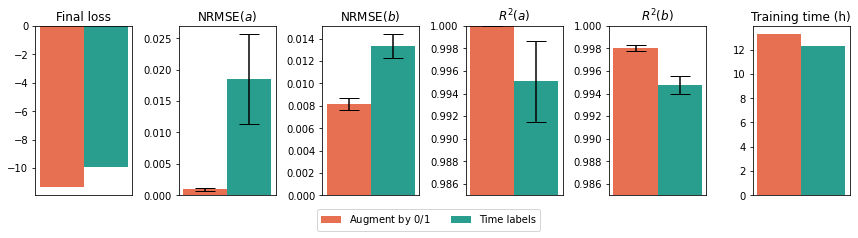

In [17]:
fig, ax = plt.subplots(1, 6, figsize=(12, 3))

bar_chart(
    ax, np.array([loss_augment01, loss_time]), 0, 'Final loss',
)

bar_chart(
    ax, np.array([metrics_augment01[0,0], metrics_time[0,0]]), 1, 'NRMSE$(a)$', 
    se=np.array([metrics_augment01[1,0], metrics_time[1,0]]),
)
bar_chart(
    ax, np.array([metrics_augment01[0,1], metrics_time[0,1]]), 2, 'NRMSE$(b)$', 
    se=np.array([metrics_augment01[1,1], metrics_time[1,1]]),
)
bar_chart(
    ax, np.array([metrics_augment01[0,2], metrics_time[0,2]]), 3, '$R^2(a)$', 
    se=np.array([metrics_augment01[1,2], metrics_time[1,2]]), 
    y_lim=np.array([0.985, 1])
)
bar_chart(
    ax, np.array([metrics_augment01[0,3], metrics_time[0,3]]), 4, '$R^2(b)$', 
    se=np.array([metrics_augment01[1,3], metrics_time[1,3]]), 
    y_lim=np.array([0.985, 1]), 
)
bar_chart(
    ax, np.array([13+18/60, 12+18/60]), 5, 'Training time (h)', 
)

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.11), ncol=4)
plt.tight_layout()
plt.show()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Osc_metrics.{fmt}", dpi=300, bbox_inches='tight')